In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
train = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/train', transform = transform)
test = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/test', transform = transform)

In [4]:
train_loader = DataLoader(train, batch_size=16, shuffle=True)
test_loader = DataLoader(test, batch_size=16, shuffle=True)

In [5]:
print(train.classes)

['0', '1']


In [6]:
x, y = next(iter(train))

In [7]:
print(x)

tensor([[[ 0.0569,  0.1083, -0.0458,  ...,  2.2489,  2.2489,  2.2489],
         [ 0.0912,  0.1254, -0.1143,  ...,  2.2489,  2.2489,  2.2489],
         [ 0.0227,  0.0227, -0.1657,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

        [[ 0.1877,  0.2402,  0.0826,  ...,  2.4286,  2.4286,  2.4286],
         [ 0.2227,  0.2577,  0.0126,  ...,  2.4286,  2.4286,  2.4286],
         [ 0.1527,  0.1527, -0.0399,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

        [[ 0.4091,  0.4614,  0.3045,  ...,  2.6400,  2.6400,  2.6400],
         [ 0.4439,  0.4788,  0.2348,  ...,  2

In [8]:
print(y)

0


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.BatchNorm2d(16), 
            nn.GELU(),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128), 
            nn.GELU(),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.GELU()
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128), 
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.GELU()
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layer = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 2)
        )


    def forward(self, X):
        data = self.conv_layer_1(X)
        data = self.conv_layer_2(data)
        data = self.conv_layer_3(data)
        data = self.pool(data)
        data = torch.flatten(data, 1)
        return self.fc_layer(data)

In [10]:
model = CNN()

In [11]:
model

CNN(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): GELU(approximate='none')
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [12]:
num_epochs = 10

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model.to(device)

CNN(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): GELU(approximate='none')
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [16]:
model.train()

for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0

    num_batches = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch: {epoch + 1} / {num_epochs}, mean loss on epoch: {running_loss / num_batches}")

 10%|█         | 1/10 [01:01<09:09, 61.01s/it]

Epoch: 1 / 10, mean loss on epoch: 0.6681782631266037


 20%|██        | 2/10 [01:47<07:01, 52.72s/it]

Epoch: 2 / 10, mean loss on epoch: 0.6341140830276797


 30%|███       | 3/10 [02:34<05:50, 50.03s/it]

Epoch: 3 / 10, mean loss on epoch: 0.6343925965312344


 40%|████      | 4/10 [03:21<04:51, 48.62s/it]

Epoch: 4 / 10, mean loss on epoch: 0.6292762068294039


 50%|█████     | 5/10 [04:08<04:00, 48.04s/it]

Epoch: 5 / 10, mean loss on epoch: 0.6272405101948937


 60%|██████    | 6/10 [04:55<03:10, 47.61s/it]

Epoch: 6 / 10, mean loss on epoch: 0.6298801354913903


 70%|███████   | 7/10 [05:42<02:22, 47.60s/it]

Epoch: 7 / 10, mean loss on epoch: 0.628307560146255


 80%|████████  | 8/10 [06:29<01:34, 47.39s/it]

Epoch: 8 / 10, mean loss on epoch: 0.6287216124118574


 90%|█████████ | 9/10 [07:16<00:47, 47.22s/it]

Epoch: 9 / 10, mean loss on epoch: 0.6283660787063957


100%|██████████| 10/10 [08:03<00:00, 48.31s/it]

Epoch: 10 / 10, mean loss on epoch: 0.6255842759305199


In [17]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.res_1 = nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=2, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32)
        )

        self.downsample_1 = nn.Sequential(
            nn.Conv2d(16, 32, 1, stride=2),
            nn.BatchNorm2d(32)
        )

        self.res_2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64)
        )

        self.downsample_2 = nn.Sequential(
            nn.Conv2d(32, 64, 1, stride=2),
            nn.BatchNorm2d(64)
        )

        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = self.stem(x)

        identity = x
        identity = self.downsample_1(identity)
        
        out = self.res_1(x)
        out += identity
        out = self.relu(out)

        identity = out
        identity = self.downsample_2(identity)

        out = self.res_2(out)
        out += identity
        out = self.relu(out)

        out = self.pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [18]:
res = ResNet().to(device)

In [19]:
optimizer = torch.optim.Adam(res.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [20]:
num_epochs = 5

In [21]:
res.train()

for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0

    num_batches = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = res(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch: {epoch + 1} / {num_epochs}, mean loss on epoch: {running_loss / num_batches}")

 20%|██        | 1/5 [00:29<01:59, 29.89s/it]

Epoch: 1 / 5, mean loss on epoch: 0.6394346652414975


 40%|████      | 2/5 [00:59<01:28, 29.66s/it]

Epoch: 2 / 5, mean loss on epoch: 0.6364171917006474


 60%|██████    | 3/5 [01:29<00:59, 29.82s/it]

Epoch: 3 / 5, mean loss on epoch: 0.6352493518950956


 80%|████████  | 4/5 [01:59<00:29, 29.87s/it]

Epoch: 4 / 5, mean loss on epoch: 0.6330199257639431


100%|██████████| 5/5 [02:28<00:00, 29.78s/it]

Epoch: 5 / 5, mean loss on epoch: 0.6335322336862551


In [22]:
res_pre = models.resnet34(pretrained = True)
res_pre.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [24]:
train_res = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/train', transform = preprocess)

In [25]:
train_res_loader = DataLoader(train_res, batch_size=16, shuffle=True)

In [26]:
res_pre.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
with torch.no_grad():
    running_loss = 0.0
    batch_counter = 0
    for inputs, labels in train_res_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        out = res_pre(inputs)
        loss = criterion(out, labels.long())

        running_loss += loss.item()
        batch_counter += 1
    print(f"Loss: {running_loss / len(train_res_loader)}")

Loss: 10.909903187079717


In [28]:
res_pre.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
optimizer = torch.optim.Adam(res_pre.parameters(), lr=1e-4)

In [30]:
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0

    num_batches = 0
    for inputs, labels in train_res_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = res_pre(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch: {epoch + 1} / {num_epochs}, mean loss on epoch: {running_loss / num_batches}")

 20%|██        | 1/5 [00:21<01:26, 21.55s/it]

Epoch: 1 / 5, mean loss on epoch: 1.7266715921011546


 40%|████      | 2/5 [00:43<01:05, 21.82s/it]

Epoch: 2 / 5, mean loss on epoch: 0.5841554837338876


 60%|██████    | 3/5 [01:05<00:43, 21.68s/it]

Epoch: 3 / 5, mean loss on epoch: 0.477645970530958


 80%|████████  | 4/5 [01:26<00:21, 21.73s/it]

Epoch: 4 / 5, mean loss on epoch: 0.3840688699543876


100%|██████████| 5/5 [01:48<00:00, 21.73s/it]

Epoch: 5 / 5, mean loss on epoch: 0.2755278554438745


In [31]:
res_50 = models.resnet101(pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 225MB/s] 


In [32]:
res_50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
optimizer = torch.optim.Adam(res_50.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [34]:
for epoch in tqdm(range(10)):
    running_loss = 0.0

    num_batches = 0
    for inputs, labels in train_res_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = res_50(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch: {epoch + 1} / 10, mean loss on epoch: {running_loss / num_batches}")

 10%|█         | 1/10 [00:36<05:26, 36.26s/it]

Epoch: 1 / 10, mean loss on epoch: 1.3339657051451255


 20%|██        | 2/10 [01:13<04:52, 36.59s/it]

Epoch: 2 / 10, mean loss on epoch: 0.5386938928757738


 30%|███       | 3/10 [01:49<04:16, 36.60s/it]

Epoch: 3 / 10, mean loss on epoch: 0.4194289242861255


 40%|████      | 4/10 [02:26<03:40, 36.74s/it]

Epoch: 4 / 10, mean loss on epoch: 0.3267156422738261


 50%|█████     | 5/10 [03:03<03:03, 36.75s/it]

Epoch: 5 / 10, mean loss on epoch: 0.24348056468887616


 60%|██████    | 6/10 [03:40<02:26, 36.74s/it]

Epoch: 6 / 10, mean loss on epoch: 0.16784656091574454


 70%|███████   | 7/10 [04:16<01:50, 36.74s/it]

Epoch: 7 / 10, mean loss on epoch: 0.11176092165753546


 80%|████████  | 8/10 [04:53<01:13, 36.61s/it]

Epoch: 8 / 10, mean loss on epoch: 0.14420689230834777


 90%|█████████ | 9/10 [05:30<00:36, 36.67s/it]

Epoch: 9 / 10, mean loss on epoch: 0.14639342781593837


100%|██████████| 10/10 [06:06<00:00, 36.67s/it]

Epoch: 10 / 10, mean loss on epoch: 0.0916890645315308


In [35]:
test_res = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/test', transform = preprocess)
test_res_loader = DataLoader(test_res, batch_size=16, shuffle=True)

In [36]:
res_50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_res_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = res_50(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [38]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       208
           1       0.56      0.38      0.46       128

    accuracy                           0.65       336
   macro avg       0.62      0.60      0.60       336
weighted avg       0.64      0.65      0.63       336



In [39]:
device = 'cuda'

In [40]:
class GigaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 =  models.efficientnet.efficientnet_b3(pretrained=True)
        self.mlp = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, X):
        out = self.layer_1(X)
        out = self.mlp(out)
        return out

In [41]:
train = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/train', transform = preprocess)
test = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/test', transform = preprocess)

In [42]:
model = GigaNet()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 190MB/s]


In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
model.to(device)

GigaNet(
  (layer_1): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_act

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [47]:
train = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/train', transform = preprocess)
test = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/test', transform = preprocess)

In [48]:
train_loader = DataLoader(train, batch_size=8, shuffle=True)

In [49]:
model.train()

for epoch in range(5):
    running_loss = 0.0

    num_batches = 0
    for inputs, labels in (bar := tqdm(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
        bar.set_description(f"Epoch: {epoch + 1}, Loss by batch: {loss.item():.4f}")

    print(f"Epoch: {epoch + 1}, mean loss on epoch: {running_loss / num_batches}")

Epoch: 1, Loss by batch: 0.7753: 100%|██████████| 297/297 [00:38<00:00,  7.64it/s]


Epoch: 1, mean loss on epoch: 0.643160054177949


Epoch: 2, Loss by batch: 0.4601: 100%|██████████| 297/297 [00:38<00:00,  7.67it/s]


Epoch: 2, mean loss on epoch: 0.6137255605824468


Epoch: 3, Loss by batch: 0.7839: 100%|██████████| 297/297 [00:38<00:00,  7.70it/s]


Epoch: 3, mean loss on epoch: 0.5929679882646811


Epoch: 4, Loss by batch: 0.3399: 100%|██████████| 297/297 [00:38<00:00,  7.74it/s]


Epoch: 4, mean loss on epoch: 0.5692607929008175


Epoch: 5, Loss by batch: 0.5565: 100%|██████████| 297/297 [00:38<00:00,  7.67it/s]

Epoch: 5, mean loss on epoch: 0.5422967329169764


In [50]:
test_loader = DataLoader(test, batch_size=8, shuffle = True)

In [51]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = np.argmax(outputs.cpu(), axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [52]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       208
           1       0.54      0.34      0.42       128

    accuracy                           0.64       336
   macro avg       0.60      0.58      0.58       336
weighted avg       0.62      0.64      0.62       336



In [53]:
import torch
import torch.nn as nn
from einops import rearrange

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(0.1)
        )
    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.attention(x_norm, x_norm, x_norm)
        x = x + attn_output
        x = x + self.mlp(self.norm2(x))
        return x

class OptimusPrime(nn.Module):
    def __init__(self, image_size=224, patch_size=16, num_classes=2, 
                 embed_dim=256, num_heads=8, num_layers=16):
        super().__init__()
        self.patch_embed = nn.Sequential(
            nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.GELU(),
            nn.BatchNorm2d(embed_dim)
        )
        encoder = nn.TransformerEncoderLayer(embed_dim, num_heads, 512, activation='gelu', batch_first=True)
        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.transformer_blocks = nn.TransformerEncoder(encoder, num_layers)
        self.classifier = nn.Sequential(
            # nn.LayerNorm(embed_dim),
            # nn.Dropout(0.2),
            nn.Linear(embed_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embed(x)  # [B, embed_dim, H_p, W_p]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        
        x = x + self.pos_embed  # [B, num_patches, embed_dim]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [B, num_patches+1, embed_dim]
        
        x = self.transformer_blocks(x)[:, 0, :]  # [B, embed_dim]
        return self.classifier(x)  # [B, num_classes]

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [55]:
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

In [9]:
train = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/train', transform = transform)
train_loader = DataLoader(train, batch_size=32, shuffle=True)

In [10]:
test = datasets.ImageFolder(root = '/kaggle/input/breast-cancer-detection/test', transform = transform)

In [11]:
test_loader = DataLoader(test, batch_size=32, shuffle=True)

In [12]:
device = 'cuda'

In [60]:
model = OptimusPrime()

In [61]:
model.to(device)

OptimusPrime(
  (patch_embed): Sequential(
    (0): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
    (1): GELU(approximate='none')
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (transformer_blocks): TransformerEncoder(
    (layers): ModuleList(
      (0-15): 16 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_f

In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [63]:
model.train()
losses = []
fs = []
valid = []

for epoch in range(80):
    running_loss = 0.0
    running_f1 = 0.0

    num_batches = 0
    for inputs, labels in (bar := tqdm(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
        
        
        score = f1_score(labels.detach().cpu().numpy(), np.argmax(outputs.detach().cpu().numpy(), axis=1))
        running_f1 += score
        bar.set_description(f"Epoch: {epoch + 1}, Loss by batch: {loss.item():.4f}, F1 by epoch: {score:.4f}")


    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            outputs = model(inputs)
            preds = np.argmax(outputs.cpu(), axis=1)
    
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1_valid = f1_score(all_labels, all_preds)
    print(f"Epoch: {epoch + 1}, mean loss on epoch: {running_loss / num_batches}, mean F1: {running_f1 / num_batches}, F1 valid: {f1_valid}")
    valid.append(f1_valid)
    losses.append(running_loss / num_batches)
    fs.append(running_f1 / num_batches)

Epoch: 1, Loss by batch: 0.7349, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


Epoch: 1, mean loss on epoch: 0.6577365533510844, mean F1: 0.05177190101501541, F1 valid: 0.0


Epoch: 2, Loss by batch: 0.6280, F1 by epoch: 0.0000:  99%|█████████▊| 74/75 [00:25<00:00,  2.77it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 2, Loss by batch: 0.4353, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.95it/s]


Epoch: 2, mean loss on epoch: 0.6372070097923279, mean F1: 0.0, F1 valid: 0.0


Epoch: 3, Loss by batch: 0.7544, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 3, mean loss on epoch: 0.637959154844284, mean F1: 0.0, F1 valid: 0.0


Epoch: 4, Loss by batch: 0.6622, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 4, mean loss on epoch: 0.636337411403656, mean F1: 0.0, F1 valid: 0.0


Epoch: 5, Loss by batch: 0.7783, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 5, mean loss on epoch: 0.6374804961681366, mean F1: 0.0, F1 valid: 0.0


Epoch: 6, Loss by batch: 0.8378, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.93it/s]


Epoch: 6, mean loss on epoch: 0.6351037871837616, mean F1: 0.0, F1 valid: 0.0


Epoch: 7, Loss by batch: 0.5803, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s]


Epoch: 7, mean loss on epoch: 0.6339050849278768, mean F1: 0.010666666666666668, F1 valid: 0.0


Epoch: 8, Loss by batch: 0.5466, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 8, mean loss on epoch: 0.6316010920206706, mean F1: 0.0038095238095238095, F1 valid: 0.0


Epoch: 9, Loss by batch: 0.6362, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 9, mean loss on epoch: 0.6319611811637879, mean F1: 0.007811447811447812, F1 valid: 0.0


Epoch: 10, Loss by batch: 0.8902, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 10, mean loss on epoch: 0.6339708558718363, mean F1: 0.009489769489769491, F1 valid: 0.0


Epoch: 11, Loss by batch: 0.5043, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 11, mean loss on epoch: 0.6289479311307271, mean F1: 0.014253968253968253, F1 valid: 0.0


Epoch: 12, Loss by batch: 0.8104, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s]


Epoch: 12, mean loss on epoch: 0.6315526843070984, mean F1: 0.009102564102564104, F1 valid: 0.0


Epoch: 13, Loss by batch: 0.7008, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.94it/s]


Epoch: 13, mean loss on epoch: 0.6295396248499553, mean F1: 0.0, F1 valid: 0.0


Epoch: 14, Loss by batch: 0.6411, F1 by epoch: 0.0000:  99%|█████████▊| 74/75 [00:25<00:00,  2.89it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 14, Loss by batch: 0.3653, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.88it/s]


Epoch: 14, mean loss on epoch: 0.6272469226519267, mean F1: 0.009733821733821734, F1 valid: 0.0


Epoch: 15, Loss by batch: 0.7864, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.93it/s]


Epoch: 15, mean loss on epoch: 0.632090113957723, mean F1: 0.011471761354114294, F1 valid: 0.0


Epoch: 16, Loss by batch: 0.9998, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s]


Epoch: 16, mean loss on epoch: 0.6319673442840577, mean F1: 0.0, F1 valid: 0.0


Epoch: 17, Loss by batch: 0.4532, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s]


Epoch: 17, mean loss on epoch: 0.6234878945350647, mean F1: 0.03072882672882673, F1 valid: 0.055944055944055944


Epoch: 18, Loss by batch: 1.1259, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.88it/s]


Epoch: 18, mean loss on epoch: 0.6326615258057913, mean F1: 0.043615194116742105, F1 valid: 0.0


Epoch: 19, Loss by batch: 0.9339, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 19, mean loss on epoch: 0.6288805178801219, mean F1: 0.03751256151256151, F1 valid: 0.0


Epoch: 20, Loss by batch: 0.5224, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


Epoch: 20, mean loss on epoch: 0.6234801177183787, mean F1: 0.0719900535194653, F1 valid: 0.0


Epoch: 21, Loss by batch: 0.5878, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 21, mean loss on epoch: 0.6175888931751251, mean F1: 0.09035111775049857, F1 valid: 0.015384615384615385


Epoch: 22, Loss by batch: 0.8169, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 22, mean loss on epoch: 0.6183289837837219, mean F1: 0.125440956933217, F1 valid: 0.3106796116504854


Epoch: 23, Loss by batch: 0.4922, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 23, mean loss on epoch: 0.614003711938858, mean F1: 0.21120652206410712, F1 valid: 0.04195804195804196


Epoch: 24, Loss by batch: 0.6687, F1 by epoch: 0.1538:  99%|█████████▊| 74/75 [00:25<00:00,  2.93it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 24, Loss by batch: 0.3301, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.95it/s]


Epoch: 24, mean loss on epoch: 0.6043016028404236, mean F1: 0.2761216241409538, F1 valid: 0.015384615384615385


Epoch: 25, Loss by batch: 0.7813, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 25, mean loss on epoch: 0.6055214524269104, mean F1: 0.2697136144442645, F1 valid: 0.13157894736842105


Epoch: 26, Loss by batch: 0.4345, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 26, mean loss on epoch: 0.596686824162801, mean F1: 0.29332257353929164, F1 valid: 0.2417582417582417


Epoch: 27, Loss by batch: 0.6996, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 27, mean loss on epoch: 0.5994670557975769, mean F1: 0.34033992402730157, F1 valid: 0.2117647058823529


Epoch: 28, Loss by batch: 0.5389, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.93it/s]


Epoch: 28, mean loss on epoch: 0.5862337366739909, mean F1: 0.3698479243223601, F1 valid: 0.06896551724137931


Epoch: 29, Loss by batch: 0.4266, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 29, mean loss on epoch: 0.5714792370796203, mean F1: 0.4239367738931789, F1 valid: 0.2903225806451613


Epoch: 30, Loss by batch: 0.6425, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:25<00:00,  2.94it/s]


Epoch: 30, mean loss on epoch: 0.583399297396342, mean F1: 0.40812430564836905, F1 valid: 0.4083333333333333


Epoch: 31, Loss by batch: 0.5834, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 31, mean loss on epoch: 0.5582553243637085, mean F1: 0.4808173435026308, F1 valid: 0.2391304347826087


Epoch: 32, Loss by batch: 0.3786, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 32, mean loss on epoch: 0.5472089227040609, mean F1: 0.5114005135094472, F1 valid: 0.3207547169811321


Epoch: 33, Loss by batch: 0.4280, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 33, mean loss on epoch: 0.5508568863073985, mean F1: 0.4909945328097775, F1 valid: 0.32673267326732675


Epoch: 34, Loss by batch: 0.5569, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 34, mean loss on epoch: 0.5352147750059764, mean F1: 0.4974355054187872, F1 valid: 0.421875


Epoch: 35, Loss by batch: 0.6074, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s]


Epoch: 35, mean loss on epoch: 0.5230891335010529, mean F1: 0.541560991303859, F1 valid: 0.2828282828282828


Epoch: 36, Loss by batch: 1.0078, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 36, mean loss on epoch: 0.5100506508350372, mean F1: 0.5471123454704443, F1 valid: 0.27586206896551724


Epoch: 37, Loss by batch: 0.6667, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.93it/s]


Epoch: 37, mean loss on epoch: 0.5158176259199778, mean F1: 0.5605791538504419, F1 valid: 0.31527093596059114


Epoch: 38, Loss by batch: 1.0907, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.86it/s]


Epoch: 38, mean loss on epoch: 0.5045647708574931, mean F1: 0.5651204986742842, F1 valid: 0.3121951219512195


Epoch: 39, Loss by batch: 0.6043, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.94it/s]


Epoch: 39, mean loss on epoch: 0.49081353267033895, mean F1: 0.5633838056012775, F1 valid: 0.3076923076923077


Epoch: 40, Loss by batch: 0.5272, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.88it/s]


Epoch: 40, mean loss on epoch: 0.48283162275950114, mean F1: 0.5736757236073428, F1 valid: 0.3448275862068965


Epoch: 41, Loss by batch: 0.1839, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 41, mean loss on epoch: 0.46645431458950043, mean F1: 0.6136065048612994, F1 valid: 0.3474178403755868


Epoch: 42, Loss by batch: 0.7328, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 42, mean loss on epoch: 0.4574128079414368, mean F1: 0.6146425214166393, F1 valid: 0.26595744680851063


Epoch: 43, Loss by batch: 0.5558, F1 by epoch: 0.5000:  99%|█████████▊| 74/75 [00:25<00:00,  2.97it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 43, Loss by batch: 0.2430, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.95it/s]


Epoch: 43, mean loss on epoch: 0.4485136244694392, mean F1: 0.629046788651042, F1 valid: 0.2235294117647059


Epoch: 44, Loss by batch: 0.5837, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 44, mean loss on epoch: 0.44001695672671, mean F1: 0.6461258376687101, F1 valid: 0.2513661202185792


Epoch: 45, Loss by batch: 0.4971, F1 by epoch: 0.0000:  99%|█████████▊| 74/75 [00:25<00:00,  2.96it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 45, Loss by batch: 0.1228, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.93it/s]


Epoch: 45, mean loss on epoch: 0.4289444105823835, mean F1: 0.6401481859266493, F1 valid: 0.2827225130890052


Epoch: 46, Loss by batch: 1.1161, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 46, mean loss on epoch: 0.43672271609306335, mean F1: 0.642824543482526, F1 valid: 0.26804123711340205


Epoch: 47, Loss by batch: 0.8937, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 47, mean loss on epoch: 0.43798925558725993, mean F1: 0.6385472155451223, F1 valid: 0.42276422764227645


Epoch: 48, Loss by batch: 0.4290, F1 by epoch: 0.7826:  99%|█████████▊| 74/75 [00:25<00:00,  2.84it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 48, Loss by batch: 0.2020, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 48, mean loss on epoch: 0.42672860781351724, mean F1: 0.6399963256185806, F1 valid: 0.3272727272727273


Epoch: 49, Loss by batch: 0.9538, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 49, mean loss on epoch: 0.4228147872289022, mean F1: 0.6698706253244303, F1 valid: 0.2526315789473684


Epoch: 50, Loss by batch: 0.5175, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.88it/s]


Epoch: 50, mean loss on epoch: 0.40021604716777803, mean F1: 0.668602026684622, F1 valid: 0.2285714285714286


Epoch: 51, Loss by batch: 1.1482, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 51, mean loss on epoch: 0.40043541431427004, mean F1: 0.6840781480949092, F1 valid: 0.3036649214659686


Epoch: 52, Loss by batch: 0.4149, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.88it/s]


Epoch: 52, mean loss on epoch: 0.3710129916667938, mean F1: 0.7071404560567174, F1 valid: 0.3873873873873874


Epoch: 53, Loss by batch: 0.6909, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 53, mean loss on epoch: 0.4075934060414632, mean F1: 0.6564465565614758, F1 valid: 0.2580645161290323


Epoch: 54, Loss by batch: 0.4444, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s]


Epoch: 54, mean loss on epoch: 0.3609215197960536, mean F1: 0.7177054338977779, F1 valid: 0.19753086419753085


Epoch: 55, Loss by batch: 0.3540, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 55, mean loss on epoch: 0.37484546860059104, mean F1: 0.7172207806383629, F1 valid: 0.3137254901960784


Epoch: 56, Loss by batch: 0.3016, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 56, mean loss on epoch: 0.3666393834352493, mean F1: 0.7169908155089902, F1 valid: 0.2639593908629442


Epoch: 57, Loss by batch: 0.3266, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Epoch: 57, mean loss on epoch: 0.3449862233797709, mean F1: 0.7338741945830962, F1 valid: 0.2857142857142857


Epoch: 58, Loss by batch: 0.3808, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 58, mean loss on epoch: 0.3484374441703161, mean F1: 0.7219318882450205, F1 valid: 0.1893491124260355


Epoch: 59, Loss by batch: 0.3945, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.88it/s]


Epoch: 59, mean loss on epoch: 0.33720104455947875, mean F1: 0.743668152756763, F1 valid: 0.34977578475336324


Epoch: 60, Loss by batch: 0.2716, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 60, mean loss on epoch: 0.3513293965657552, mean F1: 0.7419447506082254, F1 valid: 0.3318777292576419


Epoch: 61, Loss by batch: 1.1969, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:26<00:00,  2.85it/s]


Epoch: 61, mean loss on epoch: 0.3468662764628728, mean F1: 0.7259758950049878, F1 valid: 0.28846153846153844


Epoch: 62, Loss by batch: 0.0637, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 62, mean loss on epoch: 0.33807225823402404, mean F1: 0.7412610264463974, F1 valid: 0.29268292682926833


Epoch: 63, Loss by batch: 0.0873, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


Epoch: 63, mean loss on epoch: 0.31662121951580047, mean F1: 0.7624576310262043, F1 valid: 0.2417582417582417


Epoch: 64, Loss by batch: 1.6052, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


Epoch: 64, mean loss on epoch: 0.32422546585400897, mean F1: 0.7748043037779679, F1 valid: 0.36607142857142855


Epoch: 65, Loss by batch: 0.2917, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


Epoch: 65, mean loss on epoch: 0.3279747639099757, mean F1: 0.739919243712408, F1 valid: 0.3062200956937799


Epoch: 66, Loss by batch: 0.1968, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:26<00:00,  2.84it/s]


Epoch: 66, mean loss on epoch: 0.30967312047878903, mean F1: 0.7739483001267086, F1 valid: 0.2594594594594595


Epoch: 67, Loss by batch: 1.0887, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:26<00:00,  2.85it/s]


Epoch: 67, mean loss on epoch: 0.3204464320341746, mean F1: 0.7587993625494766, F1 valid: 0.35042735042735046


Epoch: 68, Loss by batch: 0.9243, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s]


Epoch: 68, mean loss on epoch: 0.3224598256746928, mean F1: 0.7426288131219418, F1 valid: 0.3474178403755868


Epoch: 69, Loss by batch: 0.6034, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


Epoch: 69, mean loss on epoch: 0.31443661014238994, mean F1: 0.7576327683568344, F1 valid: 0.2814070351758794


Epoch: 70, Loss by batch: 0.3046, F1 by epoch: 0.8571: 100%|██████████| 75/75 [00:26<00:00,  2.88it/s]


Epoch: 70, mean loss on epoch: 0.2863486558198929, mean F1: 0.7902812455956614, F1 valid: 0.23880597014925373


Epoch: 71, Loss by batch: 0.2159, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:26<00:00,  2.85it/s]


Epoch: 71, mean loss on epoch: 0.2881104604403178, mean F1: 0.785688156724591, F1 valid: 0.2830188679245283


Epoch: 72, Loss by batch: 2.2832, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 72, mean loss on epoch: 0.29806002040704094, mean F1: 0.7963966948988739, F1 valid: 0.35807860262008734


Epoch: 73, Loss by batch: 0.3656, F1 by epoch: 0.8000: 100%|██████████| 75/75 [00:26<00:00,  2.86it/s]


Epoch: 73, mean loss on epoch: 0.2887676850954692, mean F1: 0.7858266354220136, F1 valid: 0.3142857142857143


Epoch: 74, Loss by batch: 0.2593, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


Epoch: 74, mean loss on epoch: 0.2681091982126236, mean F1: 0.8007990743354435, F1 valid: 0.3259911894273128


Epoch: 75, Loss by batch: 0.3147, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s]


Epoch: 75, mean loss on epoch: 0.27801739434401196, mean F1: 0.7966474379074374, F1 valid: 0.2897196261682243


Epoch: 76, Loss by batch: 0.1617, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s]


Epoch: 76, mean loss on epoch: 0.268480445543925, mean F1: 0.8047101959855685, F1 valid: 0.2


Epoch: 77, Loss by batch: 0.2308, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:26<00:00,  2.86it/s]


Epoch: 77, mean loss on epoch: 0.25776145736376443, mean F1: 0.8051846293499687, F1 valid: 0.33488372093023255


Epoch: 78, Loss by batch: 0.0843, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:26<00:00,  2.85it/s]


Epoch: 78, mean loss on epoch: 0.2542151325941086, mean F1: 0.8209393639188163, F1 valid: 0.3396226415094339


Epoch: 79, Loss by batch: 0.2349, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s]


Epoch: 79, mean loss on epoch: 0.24732232381900152, mean F1: 0.8093533066210187, F1 valid: 0.25


Epoch: 80, Loss by batch: 0.1494, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:26<00:00,  2.87it/s]


Epoch: 80, mean loss on epoch: 0.2500242162744204, mean F1: 0.8212148961554389, F1 valid: 0.3918367346938776


In [64]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = np.argmax(outputs.cpu(), axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [65]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       208
           1       0.40      0.38      0.39       128

    accuracy                           0.55       336
   macro avg       0.51      0.51      0.51       336
weighted avg       0.54      0.55      0.54       336



In [17]:
def plot_training_and_validation(losses, train_fs, valid_fs, title='Learning NN by epochs'):
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = (16, 8)
    plt.rcParams['font.size'] = 12

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    plt.subplots_adjust(hspace=0.1)

    # --- Лоссы ---
    loss_color = '#FF6B6B'
    ax1.plot(losses, color=loss_color, alpha=0.7, linewidth=2.5, label='Train Loss')
    ax1.set_ylabel('Loss', color=loss_color)
    ax1.tick_params(axis='y', labelcolor=loss_color)
    ax1.set_yscale('log')

    window_size = max(1, len(losses)//20)
    smooth_loss = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(np.arange(window_size//2, len(losses)-window_size//2), smooth_loss, 
             color='#EB5353', linewidth=2, label='Smoothed Loss')

    ax1.axhline(min(losses), color=loss_color, linestyle='--', alpha=0.5)
    ax1.legend(loc='upper right')

    # --- F1-score ---
    metric_train_color = '#36A2EB'
    metric_valid_color = '#FFA500'  # оранжевый для валидации

    epochs = range(1, len(train_fs) + 1)

    ax2.plot(epochs, train_fs, color=metric_train_color, linewidth=2.5, label='Train F1-score')
    ax2.plot(epochs, valid_fs, color=metric_valid_color, linewidth=2.5, linestyle='--', label='Valid F1-score')

    ax2.set_ylabel('F1-score')
    ax2.set_xlabel('Epochs')
    ax2.tick_params(axis='y')
    ax2.axhline(max(valid_fs), color=metric_valid_color, linestyle='--', alpha=0.5)
    ax2.axhline(max(train_fs), color=metric_train_color, linestyle='--', alpha=0.5)
    ax2.legend(loc='lower right')

    plt.suptitle(title, y=0.97, fontsize=14)
    plt.show()

/tmp/ipykernel_31/911518596.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


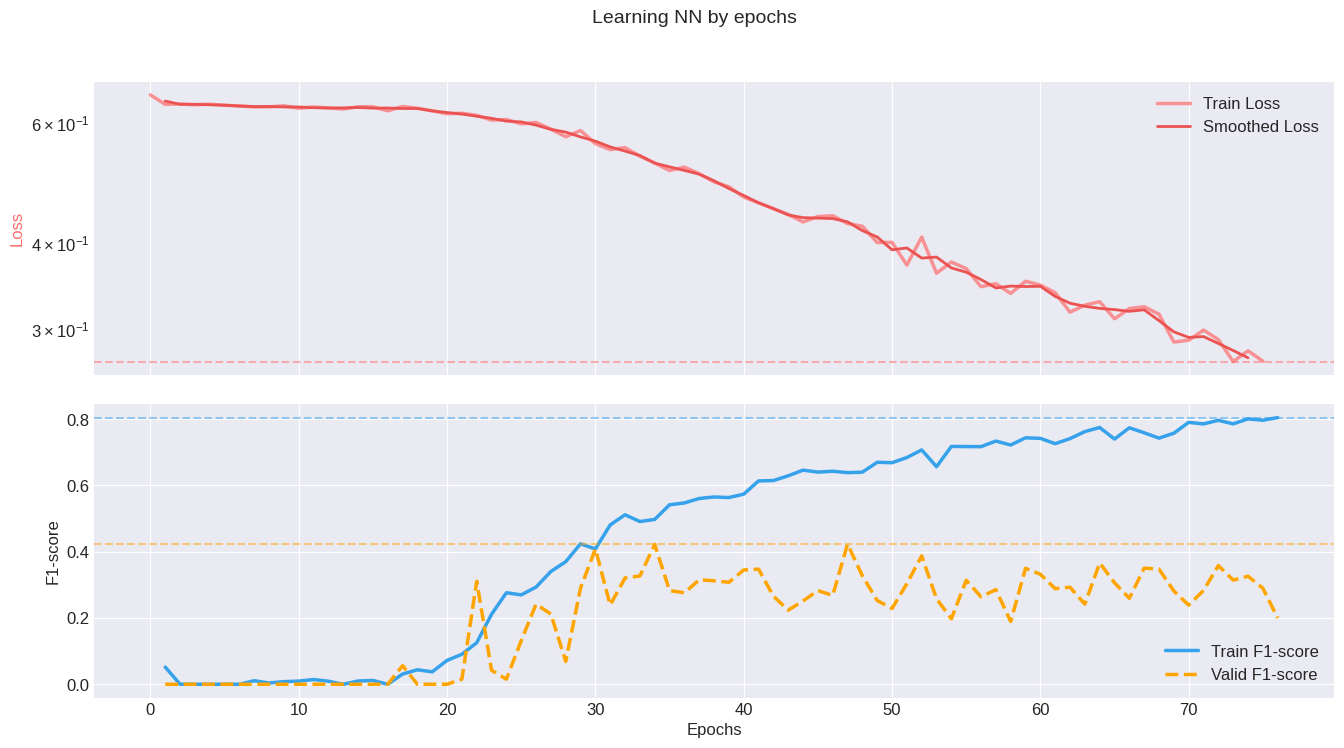

In [67]:
plot_training_and_validation(losses[:76], fs[:76], valid[:76])

# Попробуем EfficientNet

In [13]:
class GigaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 =  models.efficientnet.efficientnet_b3(pretrained=True)
        self.mlp = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, X):
        out = self.layer_1(X)
        out = self.mlp(out)
        return out

In [14]:
model = GigaNet()
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [15]:
model.train()
losses = []
fs = []
valid = []

for epoch in range(80):
    running_loss = 0.0
    running_f1 = 0.0

    num_batches = 0
    for inputs, labels in (bar := tqdm(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
        
        
        score = f1_score(labels.detach().cpu().numpy(), np.argmax(outputs.detach().cpu().numpy(), axis=1))
        running_f1 += score
        bar.set_description(f"Epoch: {epoch + 1}, Loss by batch: {loss.item():.4f}, F1 by epoch: {score:.4f}")


    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            outputs = model(inputs)
            preds = np.argmax(outputs.cpu(), axis=1)
    
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1_valid = f1_score(all_labels, all_preds)
    print(f"Epoch: {epoch + 1}, mean loss on epoch: {running_loss / num_batches}, mean F1: {running_f1 / num_batches}, F1 valid: {f1_valid}")
    valid.append(f1_valid)
    losses.append(running_loss / num_batches)
    fs.append(running_f1 / num_batches)

Epoch: 1, Loss by batch: 0.7101, F1 by epoch: 0.4000: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s]


Epoch: 1, mean loss on epoch: 0.7012866576512654, mean F1: 0.44975564119573835, F1 valid: 0.48275862068965525


Epoch: 2, Loss by batch: 0.6898, F1 by epoch: 0.8000: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch: 2, mean loss on epoch: 0.691585267384847, mean F1: 0.4146715953187429, F1 valid: 0.4


Epoch: 3, Loss by batch: 0.7361, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch: 3, mean loss on epoch: 0.6837087480227152, mean F1: 0.28251091056823474, F1 valid: 0.28888888888888886


Epoch: 4, Loss by batch: 0.6484, F1 by epoch: 0.1818:  99%|█████████▊| 74/75 [00:29<00:00,  2.42it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 4, Loss by batch: 0.6350, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.50it/s]


Epoch: 4, mean loss on epoch: 0.6707393550872802, mean F1: 0.18080142068686952, F1 valid: 0.09589041095890412


Epoch: 5, Loss by batch: 0.6418, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


Epoch: 5, mean loss on epoch: 0.6600772118568421, mean F1: 0.07019955208190504, F1 valid: 0.07518796992481203


Epoch: 6, Loss by batch: 0.6669, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 6, mean loss on epoch: 0.6483452494939168, mean F1: 0.02094749694749695, F1 valid: 0.015503875968992248


Epoch: 7, Loss by batch: 0.6747, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch: 7, mean loss on epoch: 0.6378698714574178, mean F1: 0.02420480608715903, F1 valid: 0.0


Epoch: 8, Loss by batch: 0.6326, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch: 8, mean loss on epoch: 0.6257662884394328, mean F1: 0.012784992784992788, F1 valid: 0.015503875968992248


Epoch: 9, Loss by batch: 0.5650, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


Epoch: 9, mean loss on epoch: 0.6182352105776469, mean F1: 0.0050142450142450145, F1 valid: 0.0


Epoch: 10, Loss by batch: 0.8181, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 10, mean loss on epoch: 0.6175212883949279, mean F1: 0.014105154105154106, F1 valid: 0.0


Epoch: 11, Loss by batch: 0.5645, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 11, mean loss on epoch: 0.6063629786173502, mean F1: 0.021322751322751323, F1 valid: 0.015384615384615385


Epoch: 12, Loss by batch: 0.6316, F1 by epoch: 0.0000:  99%|█████████▊| 74/75 [00:30<00:00,  2.50it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 12, Loss by batch: 0.4851, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch: 12, mean loss on epoch: 0.6024280651410421, mean F1: 0.0216737815561345, F1 valid: 0.015384615384615385


Epoch: 13, Loss by batch: 0.5386, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 13, mean loss on epoch: 0.5946308294932048, mean F1: 0.04733285233285233, F1 valid: 0.015037593984962405


Epoch: 14, Loss by batch: 0.5897, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.50it/s]


Epoch: 14, mean loss on epoch: 0.5891634353001912, mean F1: 0.04521992821992822, F1 valid: 0.030303030303030304


Epoch: 15, Loss by batch: 0.5791, F1 by epoch: 0.1667:  99%|█████████▊| 74/75 [00:29<00:00,  2.46it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 15, Loss by batch: 0.4450, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 15, mean loss on epoch: 0.5815271278222401, mean F1: 0.08577852316242408, F1 valid: 0.02962962962962963


Epoch: 16, Loss by batch: 0.7375, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 16, mean loss on epoch: 0.5797832556565603, mean F1: 0.09997310097310098, F1 valid: 0.02962962962962963


Epoch: 17, Loss by batch: 0.4499, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 17, mean loss on epoch: 0.571584069331487, mean F1: 0.16650898992075464, F1 valid: 0.11510791366906475


Epoch: 18, Loss by batch: 0.8221, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 18, mean loss on epoch: 0.5694886390368143, mean F1: 0.17178156919333387, F1 valid: 0.07042253521126761


Epoch: 19, Loss by batch: 0.7901, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch: 19, mean loss on epoch: 0.5637920598189036, mean F1: 0.24125914172972987, F1 valid: 0.08450704225352113


Epoch: 20, Loss by batch: 0.5969, F1 by epoch: 0.2857:  99%|█████████▊| 74/75 [00:29<00:00,  2.49it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 20, Loss by batch: 0.4596, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 20, mean loss on epoch: 0.5527783262729645, mean F1: 0.27964817718687685, F1 valid: 0.1610738255033557


Epoch: 21, Loss by batch: 0.5245, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.50it/s]


Epoch: 21, mean loss on epoch: 0.5458445163567861, mean F1: 0.35370437543192956, F1 valid: 0.13513513513513514


Epoch: 22, Loss by batch: 0.6619, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 22, mean loss on epoch: 0.5378782459100088, mean F1: 0.42506583841568346, F1 valid: 0.2641509433962264


Epoch: 23, Loss by batch: 0.5440, F1 by epoch: 0.2000:  99%|█████████▊| 74/75 [00:29<00:00,  2.56it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 23, Loss by batch: 0.4374, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 23, mean loss on epoch: 0.5293936733404795, mean F1: 0.4936307990828116, F1 valid: 0.22085889570552147


Epoch: 24, Loss by batch: 0.5739, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 24, mean loss on epoch: 0.5223314464092255, mean F1: 0.526658738463692, F1 valid: 0.2807017543859649


Epoch: 25, Loss by batch: 0.4489, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 25, mean loss on epoch: 0.5092190897464752, mean F1: 0.5940580628845537, F1 valid: 0.3615819209039548


Epoch: 26, Loss by batch: 0.5017, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 26, mean loss on epoch: 0.5009488594532013, mean F1: 0.62479277579781, F1 valid: 0.3723404255319149


Epoch: 27, Loss by batch: 0.6084, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 27, mean loss on epoch: 0.49157283862431844, mean F1: 0.6782573610454147, F1 valid: 0.4020618556701031


Epoch: 28, Loss by batch: 0.6351, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 28, mean loss on epoch: 0.48111984531084695, mean F1: 0.7222851756467223, F1 valid: 0.39999999999999997


Epoch: 29, Loss by batch: 0.7808, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:29<00:00,  2.50it/s]


Epoch: 29, mean loss on epoch: 0.4736805860201518, mean F1: 0.7462170306745974, F1 valid: 0.38974358974358975


Epoch: 30, Loss by batch: 0.4788, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


Epoch: 30, mean loss on epoch: 0.4596349243323008, mean F1: 0.7861588767019619, F1 valid: 0.4711538461538462


Epoch: 31, Loss by batch: 0.7944, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 31, mean loss on epoch: 0.45467423399289447, mean F1: 0.7932563319667443, F1 valid: 0.44549763033175355


Epoch: 32, Loss by batch: 0.3736, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 32, mean loss on epoch: 0.4400605110327403, mean F1: 0.8141540861707487, F1 valid: 0.43192488262910794


Epoch: 33, Loss by batch: 0.7946, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 33, mean loss on epoch: 0.43522438367207844, mean F1: 0.8360784983549103, F1 valid: 0.4137931034482759


Epoch: 34, Loss by batch: 0.3272, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch: 34, mean loss on epoch: 0.41541513641675315, mean F1: 0.8644555283192644, F1 valid: 0.4055299539170507


Epoch: 35, Loss by batch: 0.5403, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 35, mean loss on epoch: 0.41150575717290244, mean F1: 0.8553512371779247, F1 valid: 0.3943661971830986


Epoch: 36, Loss by batch: 0.3545, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.50it/s]


Epoch: 36, mean loss on epoch: 0.40172221779823303, mean F1: 0.8822617728503832, F1 valid: 0.4444444444444445


Epoch: 37, Loss by batch: 0.7023, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch: 37, mean loss on epoch: 0.40461711446444193, mean F1: 0.8666814249884186, F1 valid: 0.45045045045045046


Epoch: 38, Loss by batch: 0.5352, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 38, mean loss on epoch: 0.3972631311416626, mean F1: 0.8822055150575157, F1 valid: 0.45454545454545453


Epoch: 39, Loss by batch: 0.3593, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.50it/s]


Epoch: 39, mean loss on epoch: 0.38730581879615783, mean F1: 0.8891437052576698, F1 valid: 0.4170616113744076


Epoch: 40, Loss by batch: 0.7199, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:30<00:00,  2.50it/s]


Epoch: 40, mean loss on epoch: 0.3917658257484436, mean F1: 0.890142109548517, F1 valid: 0.4424778761061947


Epoch: 41, Loss by batch: 0.3611, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch: 41, mean loss on epoch: 0.38033032496770225, mean F1: 0.9072545887474752, F1 valid: 0.44843049327354256


Epoch: 42, Loss by batch: 0.5228, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


Epoch: 42, mean loss on epoch: 0.3693344402313232, mean F1: 0.9275618959708297, F1 valid: 0.43317972350230416


Epoch: 43, Loss by batch: 0.5936, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


Epoch: 43, mean loss on epoch: 0.37965061942736306, mean F1: 0.8998110715808093, F1 valid: 0.4186046511627907


Epoch: 44, Loss by batch: 0.3476, F1 by epoch: 1.0000:  99%|█████████▊| 74/75 [00:29<00:00,  2.48it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 44, Loss by batch: 0.4186, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 44, mean loss on epoch: 0.3729814712206523, mean F1: 0.9065481509443839, F1 valid: 0.4


Epoch: 45, Loss by batch: 0.6453, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 45, mean loss on epoch: 0.3729269397258759, mean F1: 0.9151351698463526, F1 valid: 0.44642857142857145


Epoch: 46, Loss by batch: 0.3401, F1 by epoch: 0.9655:  99%|█████████▊| 74/75 [00:29<00:00,  2.45it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 46, Loss by batch: 0.3556, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.50it/s]


Epoch: 46, mean loss on epoch: 0.37210789521535237, mean F1: 0.8981926158058561, F1 valid: 0.4888888888888889


Epoch: 47, Loss by batch: 0.3176, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 47, mean loss on epoch: 0.36565889239311217, mean F1: 0.9294228249285078, F1 valid: 0.4392523364485981


Epoch: 48, Loss by batch: 0.6236, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 48, mean loss on epoch: 0.3719019309679667, mean F1: 0.9148809509769528, F1 valid: 0.48


Epoch: 49, Loss by batch: 0.3147, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:30<00:00,  2.50it/s]


Epoch: 49, mean loss on epoch: 0.35935327609380086, mean F1: 0.9359041784268318, F1 valid: 0.4864864864864865


Epoch: 50, Loss by batch: 0.8218, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 50, mean loss on epoch: 0.3704834540685018, mean F1: 0.9092520099167167, F1 valid: 0.5381165919282511


Epoch: 51, Loss by batch: 0.6380, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 51, mean loss on epoch: 0.36497870246569314, mean F1: 0.9151110402193899, F1 valid: 0.4434389140271493


Epoch: 52, Loss by batch: 0.6395, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.50it/s]


Epoch: 52, mean loss on epoch: 0.36175758838653566, mean F1: 0.9232699755577121, F1 valid: 0.4669603524229075


Epoch: 53, Loss by batch: 0.5079, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


Epoch: 53, mean loss on epoch: 0.3537640968958537, mean F1: 0.9411685382363316, F1 valid: 0.4732142857142857


Epoch: 54, Loss by batch: 0.7640, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 54, mean loss on epoch: 0.35983675519625347, mean F1: 0.9384231484631219, F1 valid: 0.4454545454545455


Epoch: 55, Loss by batch: 0.5626, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch: 55, mean loss on epoch: 0.359725882212321, mean F1: 0.9296168549683047, F1 valid: 0.46296296296296297


Epoch: 56, Loss by batch: 0.3360, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch: 56, mean loss on epoch: 0.3504045577843984, mean F1: 0.943017343456478, F1 valid: 0.502283105022831


Epoch: 57, Loss by batch: 0.5406, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 57, mean loss on epoch: 0.3520991329352061, mean F1: 0.937775430207502, F1 valid: 0.4930232558139535


Epoch: 58, Loss by batch: 0.3139, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch: 58, mean loss on epoch: 0.3524526838461558, mean F1: 0.9386331915013356, F1 valid: 0.416289592760181


Epoch: 59, Loss by batch: 0.3450, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 59, mean loss on epoch: 0.34309040705362953, mean F1: 0.9543479075096691, F1 valid: 0.47533632286995514


Epoch: 60, Loss by batch: 0.8080, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


Epoch: 60, mean loss on epoch: 0.3548475114504496, mean F1: 0.9423950557421756, F1 valid: 0.462882096069869


Epoch: 61, Loss by batch: 0.3422, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


Epoch: 61, mean loss on epoch: 0.3474732450644175, mean F1: 0.9521399483185441, F1 valid: 0.49090909090909096


Epoch: 62, Loss by batch: 0.5569, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 62, mean loss on epoch: 0.34817075848579404, mean F1: 0.9496372578341159, F1 valid: 0.4


Epoch: 63, Loss by batch: 0.3177, F1 by epoch: 1.0000:  99%|█████████▊| 74/75 [00:29<00:00,  2.54it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 63, Loss by batch: 0.3253, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


Epoch: 63, mean loss on epoch: 0.34122352600097655, mean F1: 0.9466761344286073, F1 valid: 0.41284403669724773


Epoch: 64, Loss by batch: 0.3267, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 64, mean loss on epoch: 0.3431894973913829, mean F1: 0.9572122292653317, F1 valid: 0.46009389671361506


Epoch: 65, Loss by batch: 0.6698, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch: 65, mean loss on epoch: 0.3513777561982473, mean F1: 0.9333452638254831, F1 valid: 0.4272727272727273


Epoch: 66, Loss by batch: 0.5213, F1 by epoch: 0.8000: 100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch: 66, mean loss on epoch: 0.34675519704818725, mean F1: 0.9505362827907595, F1 valid: 0.4343891402714932


Epoch: 67, Loss by batch: 0.5596, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


Epoch: 67, mean loss on epoch: 0.35059247493743895, mean F1: 0.941621230902, F1 valid: 0.4711111111111111


Epoch: 68, Loss by batch: 0.3149, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


Epoch: 68, mean loss on epoch: 0.34294095436731975, mean F1: 0.9583453053367812, F1 valid: 0.411214953271028


Epoch: 69, Loss by batch: 0.7693, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch: 69, mean loss on epoch: 0.35273748795191445, mean F1: 0.936065469977332, F1 valid: 0.48672566371681414


Epoch: 70, Loss by batch: 0.3136, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


Epoch: 70, mean loss on epoch: 0.3393135086695353, mean F1: 0.9593852201010903, F1 valid: 0.4788732394366197


Epoch: 71, Loss by batch: 0.5627, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


Epoch: 71, mean loss on epoch: 0.34311861475308736, mean F1: 0.9458509521202457, F1 valid: 0.44651162790697674


Epoch: 72, Loss by batch: 0.7960, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


Epoch: 72, mean loss on epoch: 0.3447315752506256, mean F1: 0.9545974720192237, F1 valid: 0.5090909090909091


Epoch: 73, Loss by batch: 0.3306, F1 by epoch: 0.9524:  99%|█████████▊| 74/75 [00:30<00:00,  2.41it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 73, Loss by batch: 0.3146, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 73, mean loss on epoch: 0.3411658298969269, mean F1: 0.9466452955603099, F1 valid: 0.502283105022831


Epoch: 74, Loss by batch: 0.3205, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


Epoch: 74, mean loss on epoch: 0.341908921400706, mean F1: 0.9571341682097761, F1 valid: 0.5229357798165138


Epoch: 75, Loss by batch: 0.3435, F1 by epoch: 0.9600:  99%|█████████▊| 74/75 [00:29<00:00,  2.46it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Epoch: 75, Loss by batch: 0.3187, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


Epoch: 75, mean loss on epoch: 0.3405734411875407, mean F1: 0.9451623538101082, F1 valid: 0.4339622641509434


Epoch: 76, Loss by batch: 0.3134, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch: 76, mean loss on epoch: 0.3358977774779002, mean F1: 0.9667802033241338, F1 valid: 0.4444444444444444


Epoch: 77, Loss by batch: 0.3174, F1 by epoch: 1.0000: 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


Epoch: 77, mean loss on epoch: 0.33819425622622173, mean F1: 0.9639057654196242, F1 valid: 0.4884792626728111


Epoch: 78, Loss by batch: 0.8330, F1 by epoch: 0.5000: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 78, mean loss on epoch: 0.3448451769351959, mean F1: 0.9582839271580231, F1 valid: 0.4383561643835617


Epoch: 79, Loss by batch: 0.5210, F1 by epoch: 0.0000: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch: 79, mean loss on epoch: 0.33660900831222534, mean F1: 0.9552419946639757, F1 valid: 0.4956521739130435


Epoch: 80, Loss by batch: 0.4635, F1 by epoch: 0.6667: 100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch: 80, mean loss on epoch: 0.33976536711057026, mean F1: 0.9581169019067823, F1 valid: 0.4669603524229075


/tmp/ipykernel_31/911518596.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


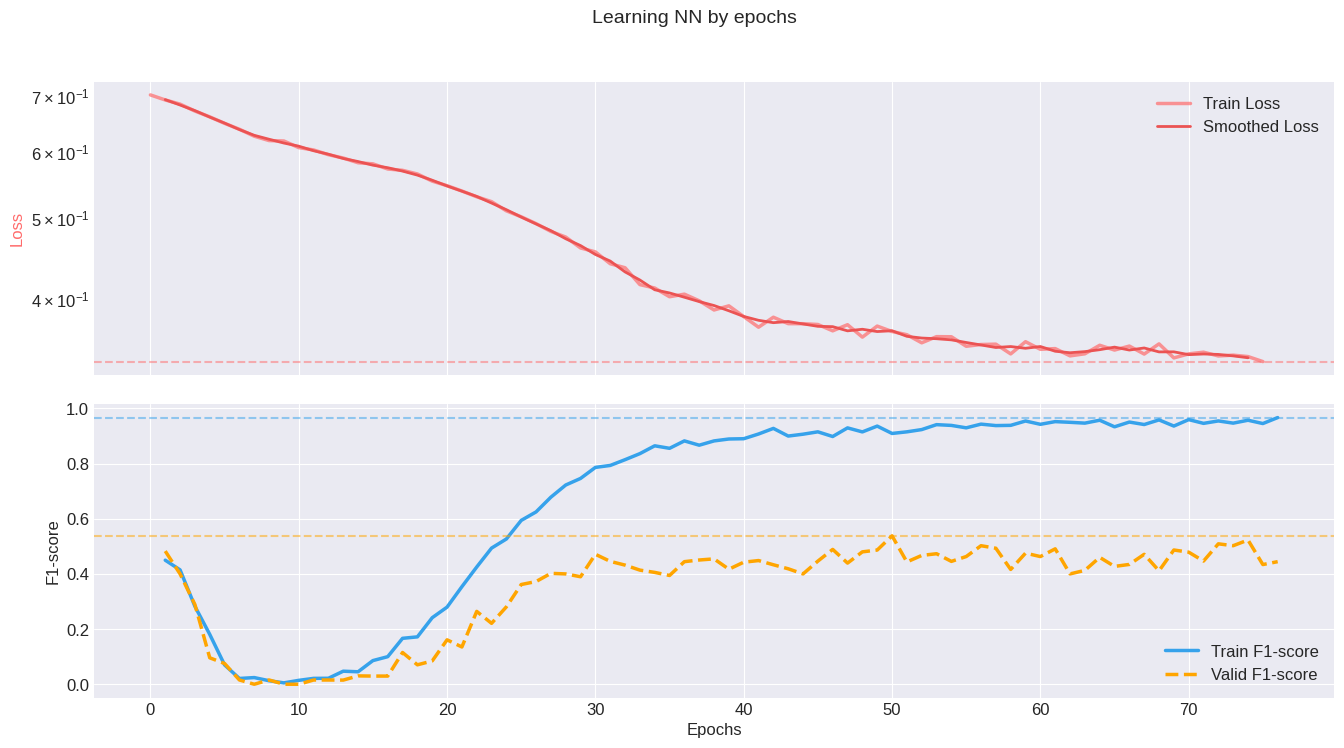

In [18]:
plot_training_and_validation(losses[:76], fs[:76], valid[:76])

In [19]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = np.argmax(outputs.cpu(), axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       416
           1       0.55      0.42      0.48       256

    accuracy                           0.65       672
   macro avg       0.62      0.60      0.60       672
weighted avg       0.63      0.65      0.63       672

